# Model analysis

In this notebook you will learn how to use the Deployment API of the Peltarion platform via Sidekick to get predictions on samples and evaluate the performance of the deployed model in more detail.

---
**NOTE!** 

For information about how to install sidekick, see https://github.com/Peltarion/sidekick

---

In [1]:
import os
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import sidekick
from tqdm import tqdm
%matplotlib inline

## Setup

### Paths

In [2]:
test_dataset_dir = './ISIC2018_Task1-2_Test_Input'
train_dataset_dir = './data'

### Client to deployment

In [3]:
deployment_url = 'https://...'
deployment_token = '...'

In [4]:
client = sidekick.Deployment(
    # Enter URL and token
    url=deployment_url,
    token=deployment_token
)

### Progress bar for Pandas

In [5]:
tqdm.pandas()

## Single predictions

Get one image file from the test dataset and resize it to the dimensions expected by the model.

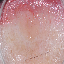

Format: JPEG
Size: (64, 64)


In [6]:
im = Image.open(os.path.join(test_dataset_dir,'ISIC_0012169.jpg'))
im = im.resize((64,64))
im.format = 'JPEG'
display(im)
print('Format: ' + im.format + '\nSize: ' + str(im.size))

Make a single prediction

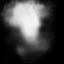

Format: JPEG
Size: (64, 64)


In [7]:
out_dict = client.predict(image=im)
display(out_dict['mask'])
print('Format: ' + im.format + '\nSize: ' + str(im.size))

## Batch predictions

Read all the files (1000) in the test input folder into a Panda dataframe. The images are scaled down to match the expected dimensions of the mode. The JPEG format information is lost after resizing and must be set explicitly. This may take a few minutes!

In [8]:
def get_image(path):
    imf = Image.open(path)
    im = imf
    im = im.resize((64,64))
    im.format = 'JPEG'
    imf.close()
    return im

In [9]:
test_images_rel_path = sorted(glob(os.path.join(test_dataset_dir, '*.jpg')))
df_test = pd.DataFrame({'image': test_images_rel_path})
df_test['image'] = df_test['image'].progress_apply(lambda path: get_image(path))
df_test.count()

100%|██████████| 1000/1000 [03:46<00:00,  7.91it/s]


image    1000
dtype: int64

For interactive exploration of data it is useful to use the `predict_lazy`
method, which returns a generator that lazily polls the deployment when needed.
This allows you to immediatly start exploring the results instead of waiting
for all predictions to finnish.

In [10]:
predictions = client.predict_lazy(df_test.to_dict('records'))

Create a generator for the images.

In [11]:
images = iter(df_test['image'])

## View image and prediction

Get next lesion image and prediction (mask) from the iterators. 
Make the mask white sections of the mask transparent and superimpose it onto the image. The first iterations will take a few seconds, successive iterations will be faster.

In [12]:
def get_masked_image(im,mask):
    mask2 = np.array(mask.convert("RGBA"))
    red, green, blue, alpha = mask2.T
    # Replace white with transparent white
    white_areas = (red >= 128) & (blue >= 128) & (green >= 128)
    mask2[white_areas.T] = (255, 0, 0, 0)
    mask2 = Image.fromarray(mask2)
    im2 = im.copy()
    im2.paste(mask2, (0, 0), mask2)
    return im2

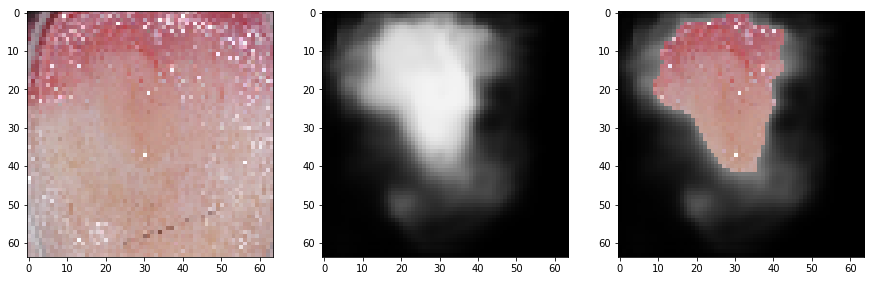

In [13]:
im = next(images)
mask = next(predictions)['mask']
masked_image = get_masked_image(im,mask)
rows = 1
columns = 3
plt.figure(figsize=(15,15))
plt.subplot(rows, columns, 1)
plt.imshow(im);
plt.subplot(rows, columns, 2)
plt.imshow(mask);
plt.subplot(rows, columns, 3)
plt.imshow(masked_image);

## View multiple images and predictions in grid

Set the desired grid size and press Run interact to get a new grid of examples.

In [14]:
from ipywidgets import interact_manual

def get_masked_image(im,mask):
    mask2 = np.array(mask.convert("RGBA"))
    red, green, blue, alpha = mask2.T
    # Replace white with transparen white
    white_areas = (red >= 128) & (blue >= 128) & (green >= 128)
    mask2[white_areas.T] = (255, 0, 0, 0)
    mask2 = Image.fromarray(mask2)
    im2 = im
    im2.paste(mask2, (0, 0), mask2)
    return im2

def show_next_grid(n_rows, n_columns):
    grid = Image.new('RGBA', (n_columns * 64, n_rows * 64))
    for column in range(n_columns):
        for row in range(n_rows):    
            im = next(images)
            mask = next(predictions)['mask']            
            masked_image = get_masked_image(im, mask)
            grid.paste(masked_image, (column * 64, row * 64))
    return grid

interact_manual(show_next_grid, n_rows=(1, 10), n_columns=(1, 10));

interactive(children=(IntSlider(value=5, description='n_rows', max=10, min=1), IntSlider(value=5, description=…

## Threshold Jaccard Index (Intersection over union)
Calculate the intersect over union for the validation set.

Read validation subset that was created in the preprocessing of the training dataset.

In [15]:
df = pd.read_csv(os.path.join(train_dataset_dir, "index.csv"))
df_val = df[df["subset"] == "V"]
print("Number of validation data samples: ", str(len(df_val)))

Number of validation data samples:  519


Change from relative to absolute paths

In [16]:
df_val['image'] = df_val['image'].progress_apply(lambda path: os.path.join(train_dataset_dir, path))
df_val['mask'] = df_val['mask'].progress_apply(lambda path: os.path.join(train_dataset_dir, path))

100%|██████████| 519/519 [00:00<00:00, 221156.54it/s]
/Users/joakim/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 519/519 [00:00<00:00, 201783.81it/s]
/Users/joakim/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Replace the paths in the image/mask columns with the actual images and mask from the subset.

In [17]:
df_val['image'] = df_val['image'].progress_apply(lambda path: get_image(path))
df_val['mask'] = df_val['mask'].progress_apply(lambda path: get_image(path))

100%|██████████| 519/519 [00:00<00:00, 1347.25it/s]
/Users/joakim/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 519/519 [00:00<00:00, 3519.93it/s]
/Users/joakim/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


This returns an iterator that will give us the mask predictions.

In [18]:
predictions = client.predict_lazy(df_val.to_dict('records'))

In [19]:
masks = iter(df_val['mask'])

Display a mask image from the validation subset and the corresponding predicted mask.

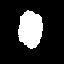

'Ground truth'

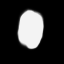

'Predicted'

In [20]:
mask = next(masks)
pred_mask = next(predictions)['mask']
display(mask,'Ground truth')
display(pred_mask, 'Predicted')

Convert masks and predicted mask to NumPy. The pixel intensity in the predicted mask will be in the range 0-255. Normalize the range to 0-1 and set a cuttoff at 50%. This means that pixels with an intensity that is lower than 128 will be considered black.

In [21]:
mask_np = np.array(mask, dtype=bool)
pred_mask_np = (np.array(pred_mask) / 255) >= .5

### Intersection (1 sample)
Display the intersecting region for a mask and its corresponding prediction, sum up the pixels in it.

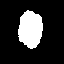

734

In [22]:
intersect_np = np.logical_and(mask_np, pred_mask_np)
intersect_sum = np.sum(intersect_np)
intersect_np = 255*intersect_np
intersect = Image.fromarray(intersect_np.astype(np.uint8))
display(intersect, intersect_sum)

### Union  (1 sample)
Display the union of a mask and its corresponding prediction, sum up the pixels in it.

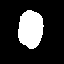

781

In [23]:
union_np = np.logical_or(mask_np, pred_mask_np)
union_sum = np.sum(union_np)
union_np = 255*union_np
union = Image.fromarray(union_np.astype(np.uint8))
display(union,union_sum)

Calculate the iou (intersection over union), which is the same thing as the threshold Jaccard index.

In [24]:
iou = intersect_sum/union_sum
print('Intersection over union {}'.format(iou))

Intersection over union 0.939820742637644


### Intersection over union  (all validation samples)

In [25]:
predictions = client.predict_lazy(df_val.to_dict('records'))
masks = df_val['mask']
pbar = tqdm(total=len(masks))
for mask in masks:
    mask_np = np.array(mask, dtype=bool)
    pred_mask = next(predictions)['mask']
    pred_mask_np = (np.array(pred_mask) / 255) >= .5
    
    intersect_np = np.logical_and(mask_np, pred_mask_np)
    intersect_sum += np.sum(intersect_np)
    union_np = np.logical_or(mask_np, pred_mask_np)
    union_sum += np.sum(union_np)
    pbar.update(1)
iou=intersect_sum/union_sum
iou

 99%|█████████▉| 513/519 [00:33<00:11,  1.87s/it]

0.7761203574310256

100%|██████████| 519/519 [00:50<00:00,  1.87s/it]